# Filtrado de datos
Se eliminan duplicados, filas sin sinópisis y/o sin géneros. Luego se seleccionan los 18 géneros más comunes.

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Loading dataset
dataset = load_dataset("pkchwy/letterboxd-all-movie-data")

train = dataset['train']

df = pd.json_normalize(train)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

full_dump.jsonl:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/847209 [00:00<?, ? examples/s]

In [ ]:
# filter all
filtered_df =  df.drop_duplicates(subset=['title'])

zero_genres = filtered_df['genres'].apply(lambda x: len(x) if isinstance(x, (list, tuple)) else 0).eq(0)
filtered_df = filtered_df[~zero_genres]

zero = filtered_df['synopsis'].apply(lambda x: len(x) if isinstance(x, str) else 0).eq(0)
filtered_df = filtered_df[~zero]

top18 = [
    "Drama", "Documentary", "Comedy", "Animation",
    "Horror", "Romance", "Thriller", "Music",
    "Action", "Crime", "Family", "Adventure",
    "Fantasy", "Science Fiction", "Mistery", "History",
    "War", "Western"
]

mask = filtered_df["genres"].apply(lambda g: all(genre in top18 for genre in g))
filtered_df = filtered_df[mask].copy()
filtered_df = filtered_df[["synopsis", "genres"]]

# Creación de datasets finales (con variedad de clases)
Se separa el dataset original según su uso:

Dataset One-genre: solo películas asignadas a un único género.
Dataset Multi-genre: películas con más de un género asignado.

Para cada uno se hará a su vez un split 80-10-10





## One Genre

In [ ]:
one_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 1)]
unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

for genre in unique_genres:
  count = len(one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)])
  if count < 1500:
    one_genre_df = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] != genre)]

unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

selected_films = {}
for genre in unique_genres:
  selected_films[genre] = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)].sort_values(by="synopsis", ascending=False)[:1500]
  selected_films[genre]["genre"] = genre
  selected_films[genre].drop(columns=["genres"], inplace=True)

one_genre_df = pd.concat(selected_films.values())

## Multigenre

In [ ]:
one_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 1)]
unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

# nos quedamos con mil muestras de cada genero para poder tener algo de variedad a la hora de aprender -> 1 genero: 18000 ejemplares
# al resto le damos la misma cantidad de ejemplares:
selected_films = {}
for genre in unique_genres:
  selected_films[genre] = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)].sort_values(by="synopsis", ascending=False)[:100]

multi_genre_df = pd.concat(selected_films.values())
print(f"1 genre real: {len(multi_genre_df)}/18000")

two_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 2)]
multi_genre_df = pd.concat([multi_genre_df, two_genre_df.sort_values(by="synopsis", ascending=False)[:1700]], axis=0)

three_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 3)]
multi_genre_df = pd.concat([multi_genre_df, three_genre_df.sort_values(by="synopsis", ascending=False)[:1700]], axis=0)


# multigenre df has the following distribution:
# 1 genre: 1800
# 2 genres: 1800
# 3 genres: 1800
# 4 genres: 1800
print(len(multi_genre_df))

1 genre real: 1700/18000
5100


# Análisis contenido de las sinopsis (por si se puede reutilizar para: ¿Existe una correlación entre la longitud de la sinopsis y el género?)

In [ ]:
import numpy as np
import html
import nltk

from nltk.corpus import stopwords
import string

nltk.download("stopwords")
all_synopsis = filtered_df["synopsis"]
len_synopsis = filtered_df["synopsis"].fillna("").apply(len).tolist()
total_empty_sinopsis = len_synopsis.count(0)
print(f"Total empty Synopsis: {total_empty_sinopsis}")

mean_len_before_filtering = np.mean(len_synopsis)
print(f"Synopsis mean len with empty: {mean_len_before_filtering}")
filtered_df = filtered_df[filtered_df["synopsis"].fillna("").apply(len) > 0]
print(f"Filtered_df len: {len(filtered_df)}")

len_synopsis = filtered_df["synopsis"].apply(len).tolist()
mean_len_before_filtering = np.mean(len_synopsis)
print(f"Synopsis mean len without empty: {mean_len_before_filtering}")

stop_words = stopwords.words("english")

def preprocess_text(text: str) -> str:
    """Limpia antes de tokenizar."""
    text = text.lower()
    text = text.replace("\\\\n", " ")
    text = html.unescape(text)
    exclude = {'#', "'", "@"}
    text = ''.join(char for char in text if char not in string.punctuation or char in exclude)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total empty Synopsis: 0
Synopsis mean len with empty: 278.60426850095996
Filtered_df len: 424505
Synopsis mean len without empty: 278.60426850095996


In [ ]:
def extract_adj_adv(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if token.pos_ in ("ADJ")]

In [ ]:
import spacy
from tqdm import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")

from collections import defaultdict, Counter

one_genre_df["modifiers"] = one_genre_df["synopsis"].progress_apply(extract_adj_adv)

genre_word_counts = defaultdict(Counter)

for _, row in one_genre_df.iterrows():
    genre_word_counts[row["genre"]].update(row["modifiers"])

genre_word_counts["Horror"].most_common(10)


100%|██████████| 19500/19500 [04:39<00:00, 69.68it/s]


[('young', 209),
 ('old', 122),
 ('new', 120),
 ('mysterious', 109),
 ('strange', 100),
 ('other', 71),
 ('dead', 70),
 ('own', 66),
 ('dark', 65),
 ('more', 63)]

Usando PMI

In [ ]:
from collections import defaultdict
import math

word_counts = defaultdict(int)
joint_counts = defaultdict(int)
genre_counts = defaultdict(int)
total_films = len(one_genre_df)

for _, row in one_genre_df.iterrows():
    genre = row["genre"]
    genre_counts[genre] += 1
    for w in row["modifiers"]:
        word_counts[w] += 1
        joint_counts[(genre, w)] += 1

def calculate_pmi(genre, word):
    p_genre = genre_counts[genre] / total_films
    p_word = word_counts[word] / total_films
    p_joint = joint_counts[(genre, word)] / total_films

    if p_genre == 0 or p_word == 0 or p_joint == 0:
        return 0.0  # Avoid division by zero or log(0)
    return math.log2(p_joint / (p_genre * p_word))

pmi_results = defaultdict(list)
for genre in genres:
    for word in word_counts:
        pmi = calculate_pmi(genre, word)
        if pmi > 0:
            pmi_results[genre].append((word, pmi))
    pmi_results[genre].sort(key=lambda x: x[1], reverse=True)


for genre in genres:
    print(f"top words for {genre}")
    for word, pmi_score in pmi_results[genre][:10]:
        print(f"  {word}: {pmi_score:.2f}")

# ¿Cuáles son los adjetivos/adverbios que están asociados a cada género?




In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

grouped = one_genre_df.groupby("genre")["modifiers"].apply(lambda words: " ".join(sum(words, [])))

genres = grouped.index.tolist()
corpus = grouped.tolist()

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(corpus)

feature_names = tfidf.get_feature_names_out()
adj_stopwords=["young","old","new","first","last","long","short"]
top_per_genre = {}
for i, genre in enumerate(genres):
    row = X[i].toarray()[0]
    top_indices = row.argsort()[-15:][::-1]
    top_per_genre[genre] = [(feature_names[j], row[j]) for j in top_indices]

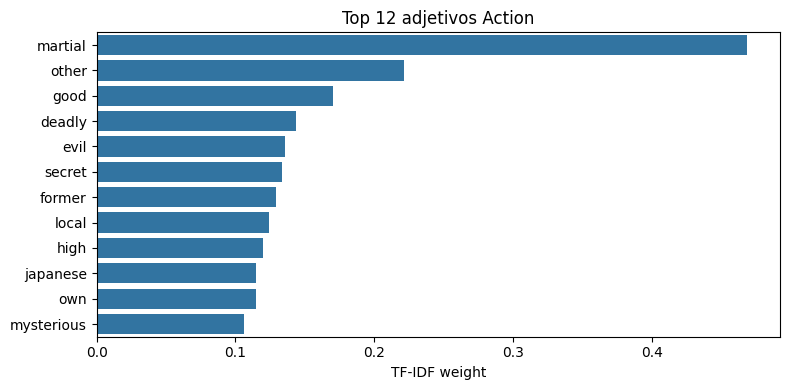

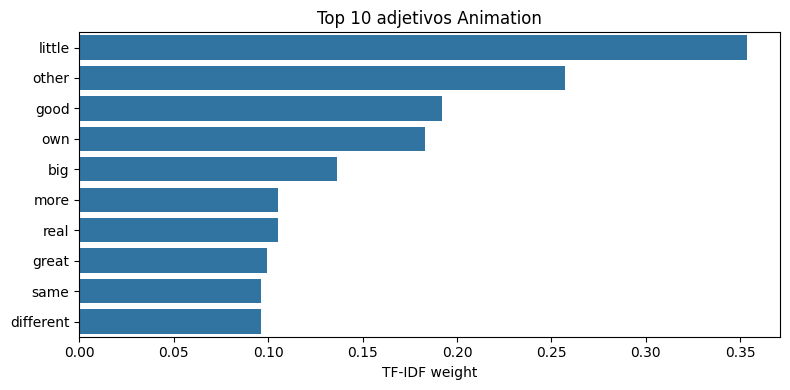

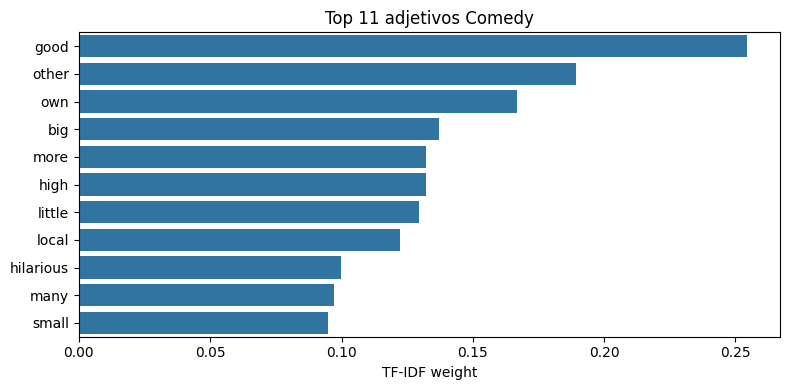

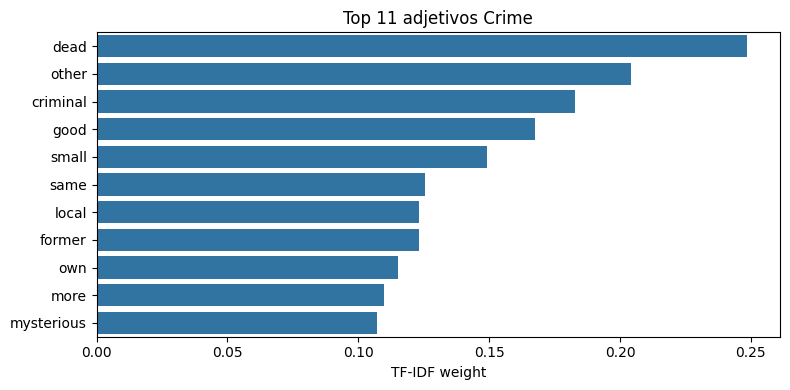

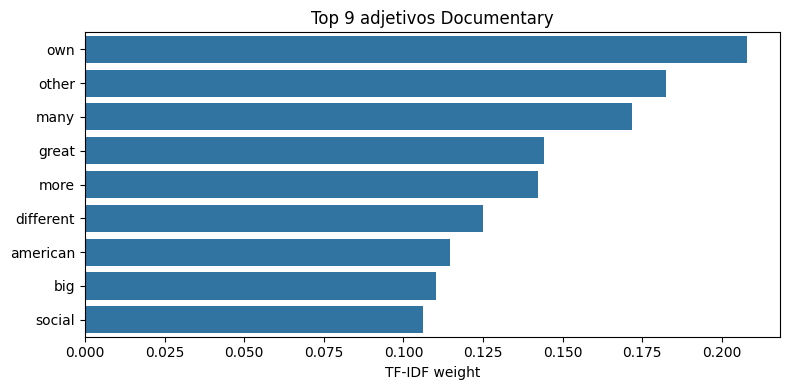

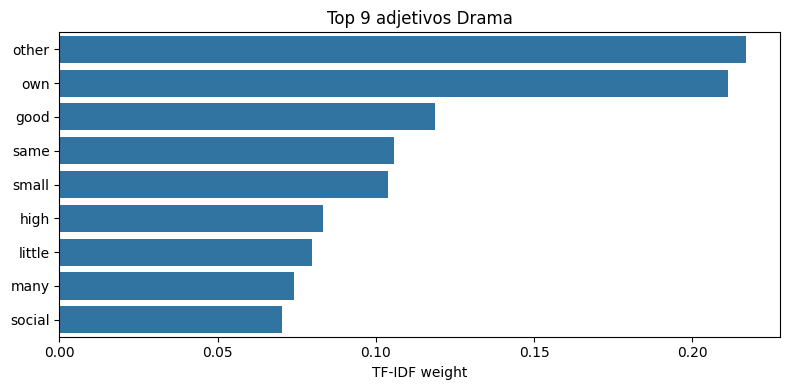

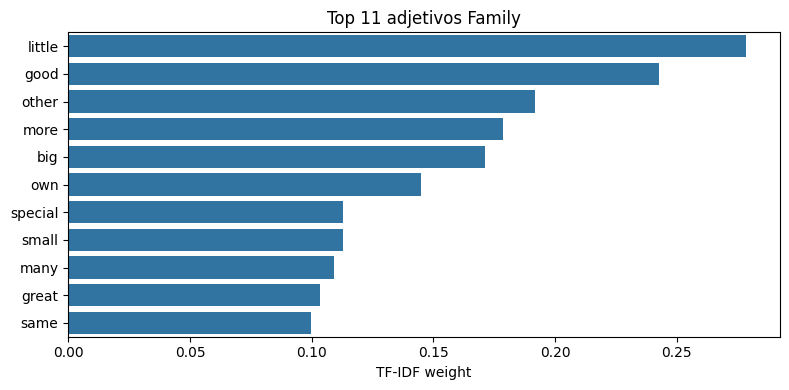

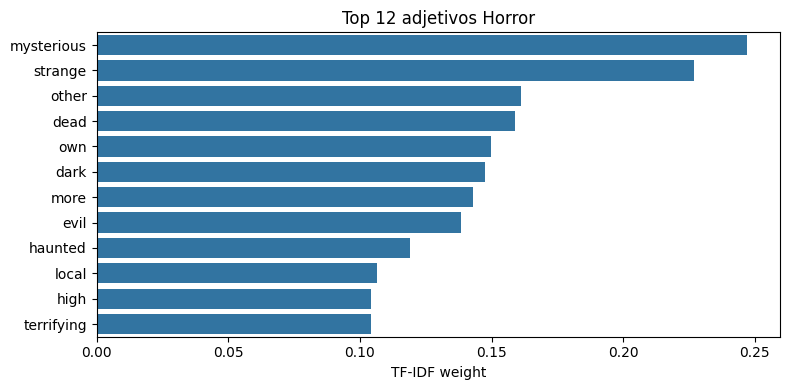

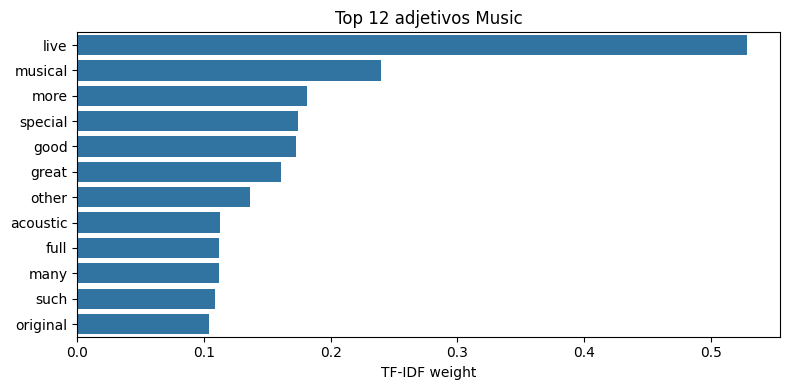

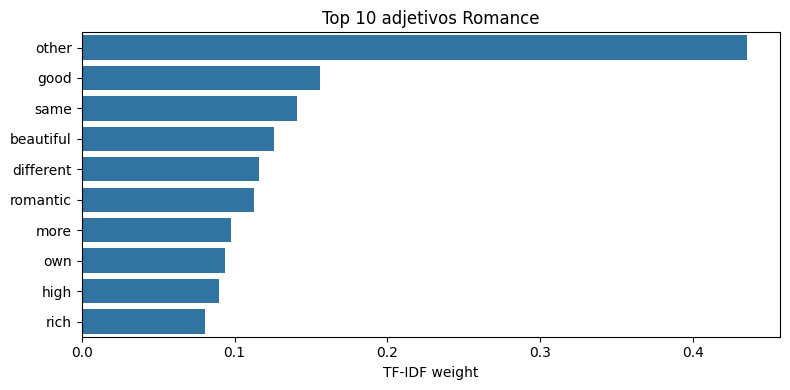

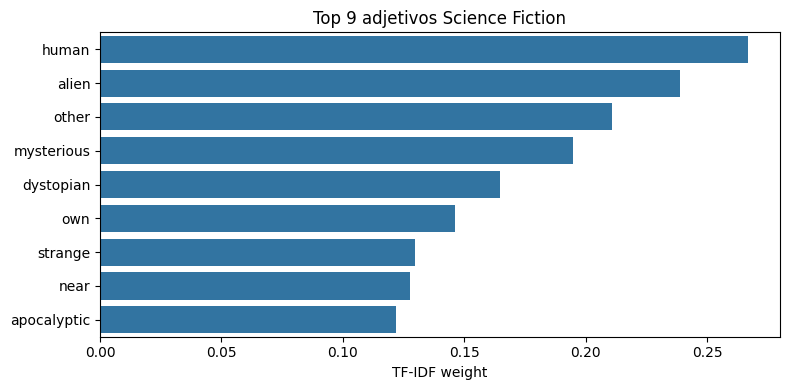

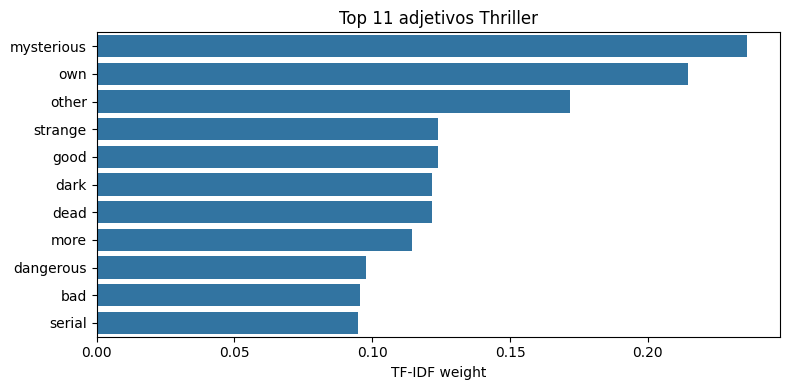

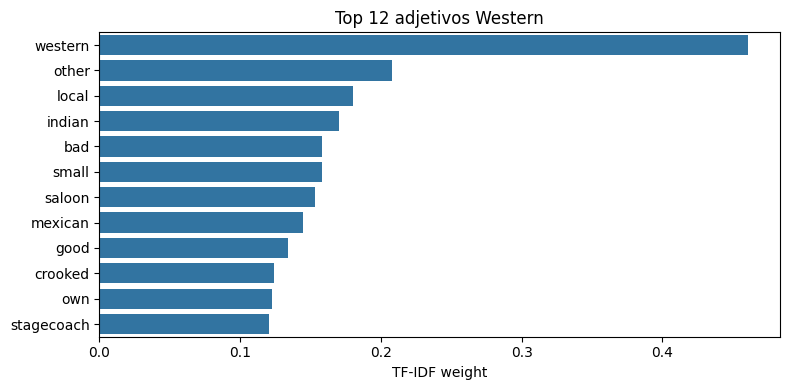

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_modifiers(genre, top_n=15):

    all_words, all_scores = zip(*top_per_genre[genre][:top_n])


    filtered_words = []
    filtered_scores = []
    for i in range(len(all_words)):
        if all_words[i] not in adj_stopwords:
            filtered_words.append(all_words[i])
            filtered_scores.append(all_scores[i])

    plt.figure(figsize=(8,4))
    sns.barplot(x=filtered_scores, y=filtered_words, orient="h")
    plt.title(f"Top {len(filtered_words)} adjetivos {genre}")
    plt.xlabel("TF-IDF weight")
    plt.tight_layout()
    plt.show()

for genre in genres:
  plot_top_modifiers(genre)

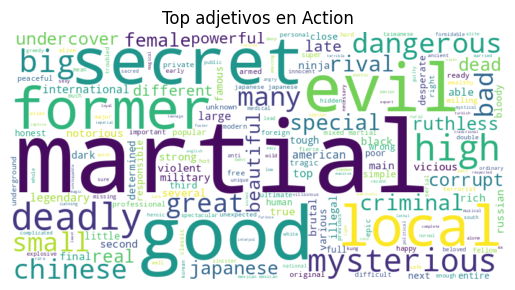

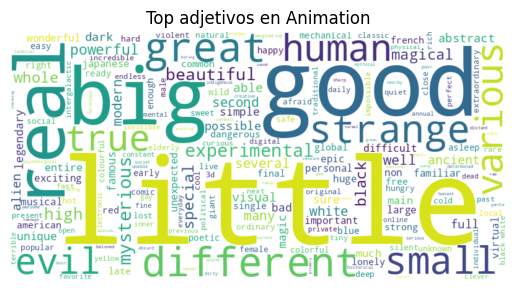

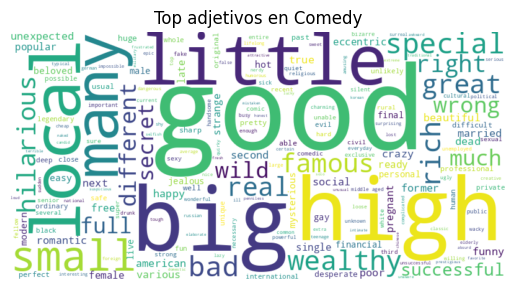

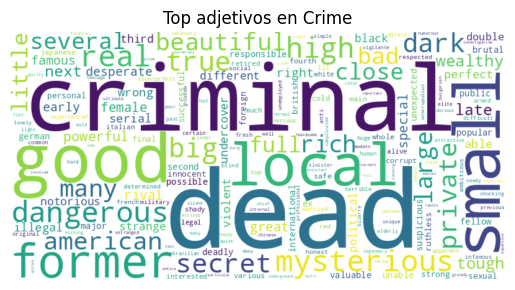

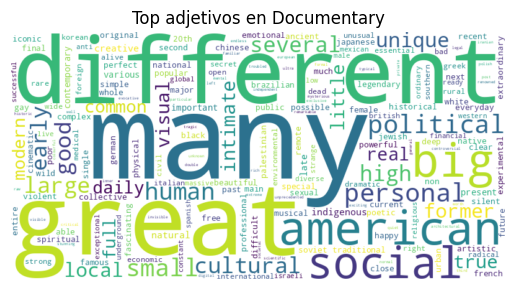

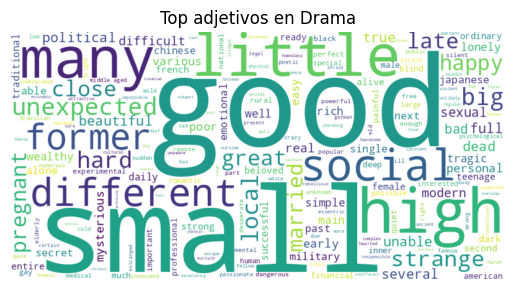

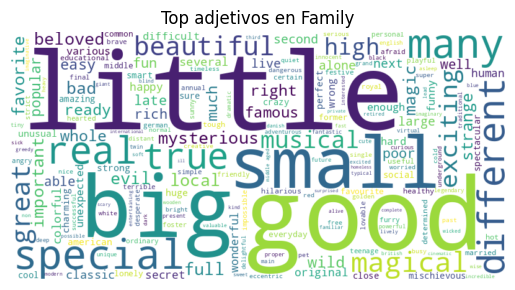

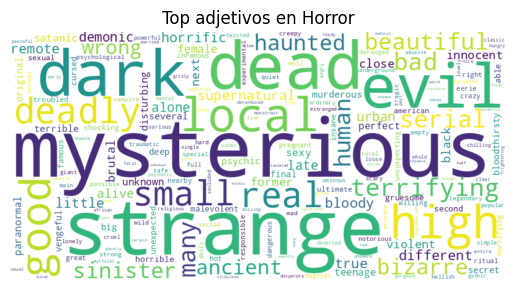

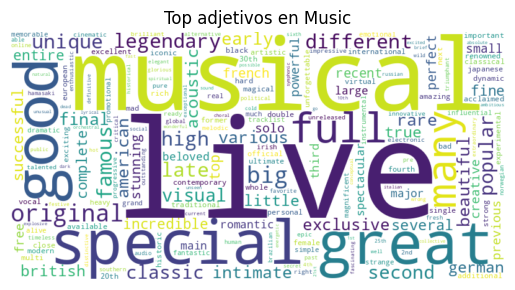

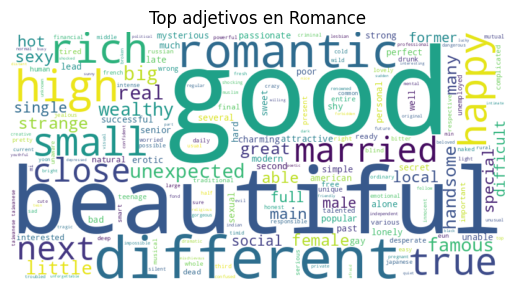

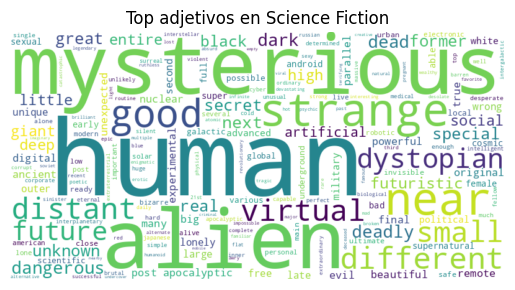

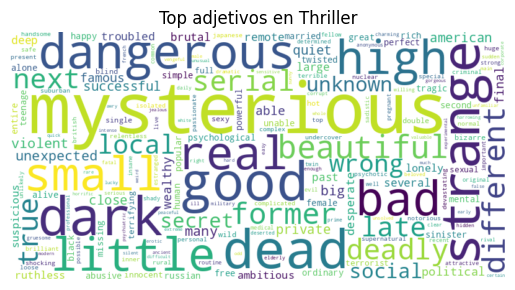

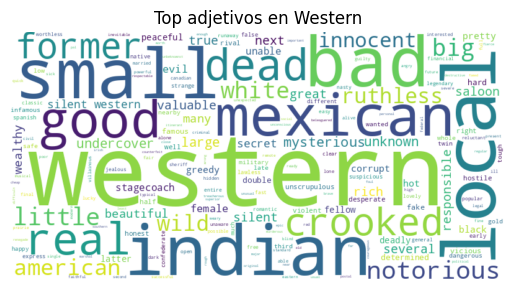

In [ ]:
from wordcloud import WordCloud

def wordcloud_for_genre(genre):
    # Filter out 'young' from the modifiers list
    filtered_modifiers = [mod for mod in one_genre_df[one_genre_df["genre"] == genre]["modifiers"].sum() if mod not in adj_stopwords]
    text = " ".join(filtered_modifiers)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.clf()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top adjetivos en {genre}")
    plt.show()

for genre in genres:
  wordcloud_for_genre(genre)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import numpy as np

train_df, test_df = train_test_split(multi_genre_df, test_size=0.2, random_state=42)

mlb = MultiLabelBinarizer()
mlb.fit(multi_genre_df["genres"])

train_df["labels"] = mlb.transform(train_df["genres"]).astype(np.float32).tolist()
test_df["labels"] = mlb.transform(test_df["genres"]).astype(np.float32).tolist()

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

NameError: name 'multi_genre_df' is not defined

In [ ]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    texts = examples["synopsis"]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256
    )

encoded_dataset = dataset_dict.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset.remove_columns(["genres", "synopsis"])
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
from transformers import AutoModelForSequenceClassification,Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import f1_score


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.5).astype(int)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

training_args = TrainingArguments(
    report_to="none",
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

eval=trainer.evaluate()

/tmp/ipython-input-2359646849.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.298811,0.473595
2,0.042300,0.289850,0.510480
3,0.032300,0.294529,0.527658
4,0.032300,0.297294,0.540478
5,0.011500,0.300964,0.536744


In [ ]:
print(eval)

<built-in function eval>


TypeError: 'builtin_function_or_method' object is not subscriptable